In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

train_fc = pd.read_csv(r"C:\Users\Kartikey\ml_project\data\forest\covtype.csv")  # adjust filename

train_fc.shape
train_fc.info()
train_fc.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [10]:
y_fc = train_fc["Cover_Type"]
y_fc.unique(), y_fc.value_counts().sort_index()


(array([5, 2, 1, 7, 3, 6, 4]),
 Cover_Type
 1    211840
 2    283301
 3     35754
 4      2747
 5      9493
 6     17367
 7     20510
 Name: count, dtype: int64)

In [ ]:
The target variable Cover_Type is encoded as integers 1–7, corresponding respectively to Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, and Krummholz.

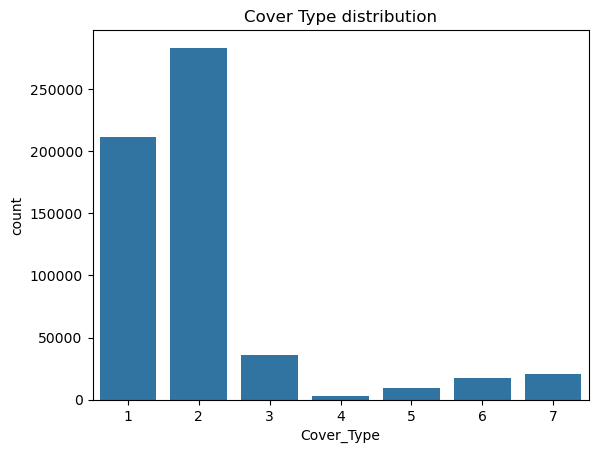

Cover_Type
2    0.487599
1    0.364605
3    0.061537
7    0.035300
6    0.029891
5    0.016339
4    0.004728
Name: proportion, dtype: float64

In [3]:
target_col = "Cover_Type"
sns.countplot(x=target_col, data=train_fc)
plt.title("Cover Type distribution")
plt.show()

train_fc[target_col].value_counts(normalize=True)


In [4]:
X_fc = train_fc.drop(columns=[target_col])
y_fc = train_fc[target_col]

cont_cols = ["Elevation", "Aspect", "Slope",
             "Horizontal_Distance_To_Hydrology",
             "Vertical_Distance_To_Hydrology",
             "Horizontal_Distance_To_Roadways",
             "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
             "Horizontal_Distance_To_Fire_Points"]

wilderness_cols = [c for c in X_fc.columns if c.startswith("Wilderness_Area")]
soil_cols       = [c for c in X_fc.columns if c.startswith("Soil_Type")]


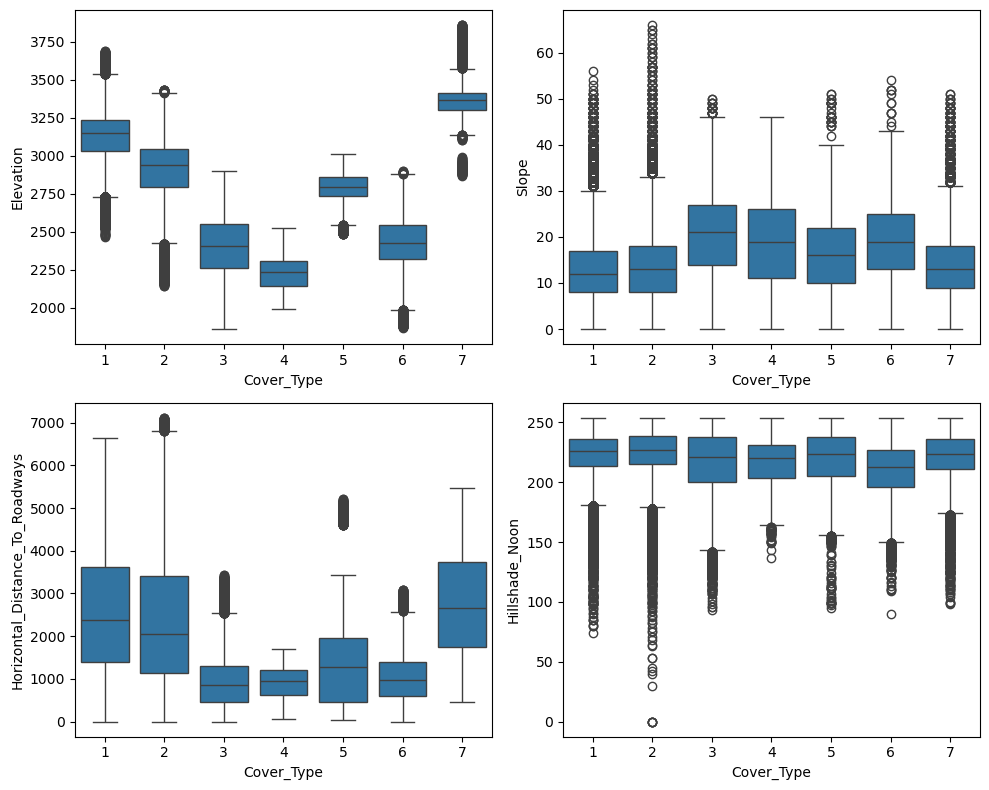

In [5]:
# Continuous feature distributions
X_fc[cont_cols].describe().T

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.boxplot(x=target_col, y="Elevation", data=train_fc, ax=axes[0,0])
sns.boxplot(x=target_col, y="Slope", data=train_fc, ax=axes[0,1])
sns.boxplot(x=target_col, y="Horizontal_Distance_To_Roadways", data=train_fc, ax=axes[1,0])
sns.boxplot(x=target_col, y="Hillshade_Noon", data=train_fc, ax=axes[1,1])
plt.tight_layout()
plt.show()


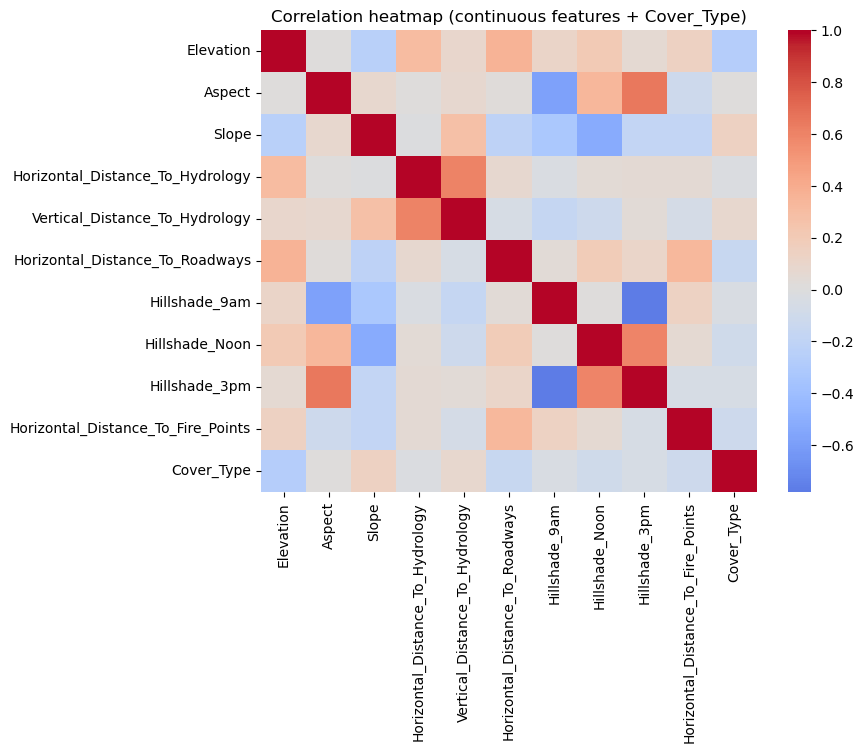

In [6]:
corr_fc = train_fc[cont_cols + [target_col]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_fc, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (continuous features + Cover_Type)")
plt.show()


*PCA*

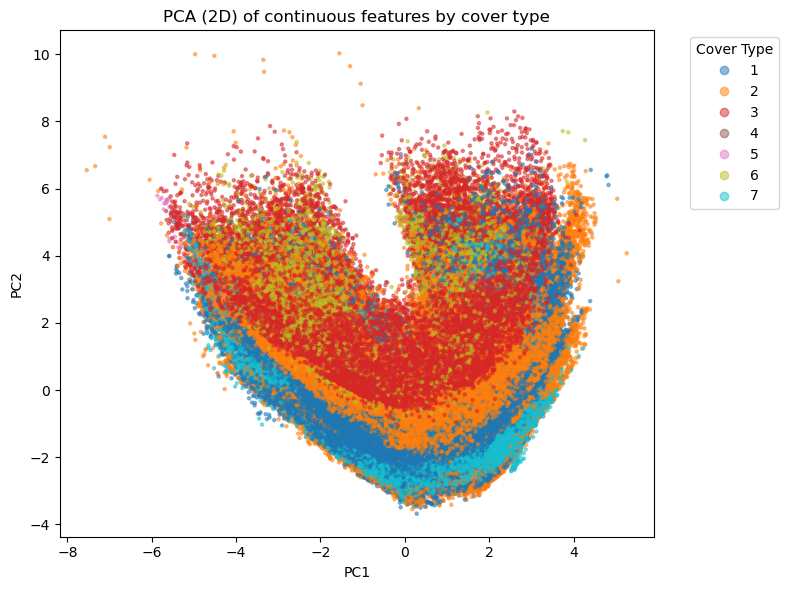

In [9]:
scaler_fc = StandardScaler()
X_fc_cont_scaled = scaler_fc.fit_transform(train_fc[cont_cols])

pca_fc = PCA(n_components=2, random_state=42)
X_pca_fc = pca_fc.fit_transform(X_fc_cont_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_fc[:,0], X_pca_fc[:,1], c=y_fc, cmap="tab10", s=5, alpha=0.5)
plt.legend(*scatter.legend_elements(), title="Cover Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2D) of continuous features by cover type")
plt.tight_layout()
plt.show()

 Define columns and preprocessor

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# --- Load data ---
#already loaded above 
target_col = "Cover_Type"

X = train_fc.drop(columns=[target_col])  #remove target from features
y = train_fc[target_col]

# --- Identify continuous vs binary columns ---
# Continuous: all features EXCEPT Wildnerness_Area* and Soil_Type*
binary_cols = [c for c in X.columns if c.startswith("Wilderness_Area") or c.startswith("Soil_Type")]
cont_cols   = [c for c in X.columns if c not in binary_cols]

print(f"Continuous features: {len(cont_cols)}")
print(f"Binary features:     {len(binary_cols)}")

# --- Build Preprocessing Pipeline ---
# Scale continuous, leave binary alone ('passthrough')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cont_cols),
        ('bin', 'passthrough', binary_cols)
    ]
)


target_col = "Cover_Type"
X = train_fc.drop(columns=[target_col])  # drop ID if present
y = train_fc[target_col]

# --- Identify continuous vs binary columns ---
# Continuous: all features EXCEPT Wildnerness_Area* and Soil_Type*
binary_cols = [c for c in X.columns if c.startswith("Wilderness_Area") or c.startswith("Soil_Type")]
cont_cols   = [c for c in X.columns if c not in binary_cols]

print(f"Continuous features: {len(cont_cols)}")
print(f"Binary features:     {len(binary_cols)}")

# --- Build Preprocessing Pipeline ---
# Scale continuous, leave binary alone ('passthrough')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cont_cols),
        ('bin', 'passthrough', binary_cols)
    ]
)

Continuous features: 10
Binary features:     44
Continuous features: 10
Binary features:     44


Baseline Logistic Regression Pipeline

In [18]:
# --- Logistic Regression Baseline ---
# Using 'multi_class' since we have 7 classes
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1))
])

# Define CV (stratified because of imbalanced classes)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


Evaluate Baseline Performance

In [17]:
# Calculate baseline metrics
print("Training baseline Logistic Regression (this may take 1-2 mins)...")

acc_scores = cross_val_score(lr_pipe, X, y, cv=cv, scoring='accuracy')
f1_scores  = cross_val_score(lr_pipe, X, y, cv=cv, scoring='f1_macro')  # Macro F1 for multiclass

print(f"Baseline Accuracy:  {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"Baseline Macro F1:  {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")


Training baseline Logistic Regression (this may take 1-2 mins)...


C:\Users\Kartikey\miniconda3\envs\mlproj\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Kartikey\miniconda3\envs\mlproj\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Kartikey\miniconda3\envs\mlproj\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Kartikey\miniconda3\envs\mlproj\Lib\site-packages\sklearn\linear_model\_logisti

Baseline Accuracy:  0.7246 ± 0.0002
Baseline Macro F1:  0.5317 ± 0.0014


 Get Top Features from LR Baseline

In [19]:
# Fit the pipeline once on full data to inspect coefficients
lr_pipe.fit(X, y)

# Get feature names after preprocessing
# Continuous cols come first (from scaler), then binary cols (passed through)
feature_names = cont_cols + binary_cols

# Extract coefficients: shape (n_classes, n_features)
coeffs = lr_pipe.named_steps['clf'].coef_

# Average importance across all classes
avg_importance = np.mean(np.abs(coeffs), axis=0)

# Create a DataFrame for easy sorting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False)

print("Top 10 Important Features:")
print(feat_imp.head(10))

# Save top 3 feature names for plotting
top_features = feat_imp['Feature'].head(3).tolist()


Top 10 Important Features:
             Feature  Importance
0          Elevation    3.395435
10  Wilderness_Area1    2.927044
17        Soil_Type4    1.562311
12  Wilderness_Area3    1.375801
8      Hillshade_3pm    1.179602
13  Wilderness_Area4    1.168230
44       Soil_Type31    1.112839
16        Soil_Type3    1.111678
46       Soil_Type33    1.106348
26       Soil_Type13    1.094092


 Plot Histograms (or KDE) for Top Features

C:\Users\Kartikey\AppData\Local\Temp\ipykernel_9724\9178666.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=train_fc, x=feature, hue=target_col,


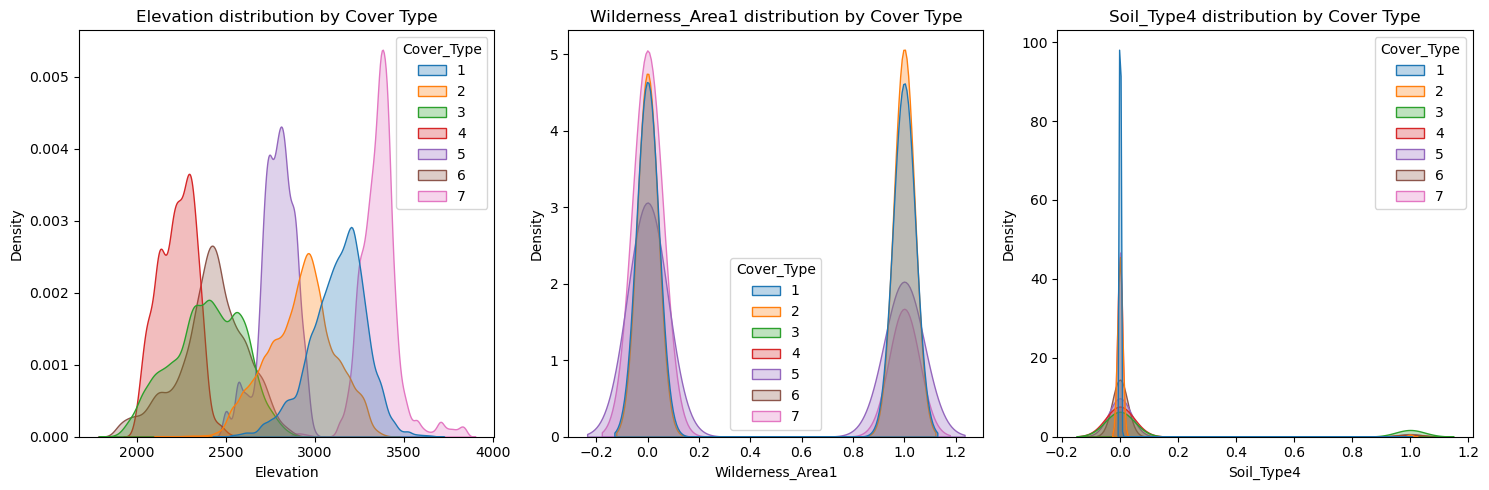

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

for i, feature in enumerate(top_features):
    plt.subplot(1, 3, i+1)
    
    # Use histplot or kdeplot. KDE is cleaner for continuous data.
    sns.kdeplot(data=train_fc, x=feature, hue=target_col, 
                palette="tab10", common_norm=False, fill=True, alpha=0.3)
    
    plt.title(f"{feature} distribution by Cover Type")
    plt.xlabel(feature)
    plt.ylabel("Density")

plt.tight_layout()
plt.show()


In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# --- SVM Pipeline (reusing the same preprocessor) ---
svm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', SVC(kernel='rbf', random_state=42))
])

# --- Hyperparameter Grid ---
param_grid_svm = {
    'clf__C': [1, 10, 100],
    'clf__gamma': ['scale', 0.1, 0.01]
}

print("Starting SVM Grid Search (this will take several minutes)...")
svm_grid = GridSearchCV(
    svm_pipe,
    param_grid=param_grid_svm,
    cv=cv,  # same StratifiedKFold(3)
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

svm_grid.fit(X, y)


NameError: name 'Pipeline' is not defined